# PSYCH253 Homework 2
### Jinxiao Zhang

## 1.1 Regression in neural data
### 1.1.1 Problem 1: Size regression from neural responses

In [1]:
#import the plotting library matplotlib
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

#other useful imports 
import numpy as np
import scipy as sp
import scipy.stats as stats
import h5py

In [2]:
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, LassoCV
# from sklearn.metrics import r2_score
from sklearn.cross_decomposition import PLSRegression

import pandas as pd
from plotnine import *

In [3]:
#loading the dataset 
# DATA_PATH = "ventral_neural_data.hdf5"
DATA_PATH = "C:/Users/tepzh/Desktop/psych253 downloads/ventral_neural_data.hdf5" ##YOUR PATH HERE
Ventral_Dataset = h5py.File(DATA_PATH, 'r')

In [4]:
#First, what is in the dataset
print(list(Ventral_Dataset.keys()))

image_size = Ventral_Dataset['image_meta']['size'][:]
print("image size shape:", image_size.shape)
print(image_size)

['image_meta', 'images', 'neural_meta', 'time_averaged', 'time_averaged_trial_averaged', 'time_binned', 'time_binned_trial_averaged']
image size shape: (5760,)
[0.81    0.81    0.81    ... 1.64492 1.22602 1.0325 ]


In [5]:
# get neural data
Neural_Data = Ventral_Dataset['time_averaged_trial_averaged'][:]
print("neural data shape:", Neural_Data.shape)

IT_NEURONS = Ventral_Dataset['neural_meta']['IT_NEURONS']
print("Number of IT neurons: ", IT_NEURONS.shape)
IT_Neural_Data = Neural_Data[:, IT_NEURONS]

V4_NEURONS = Ventral_Dataset['neural_meta']['V4_NEURONS']
V4_NEURONS = V4_NEURONS[:-40] # remove last 40 neurons
print("Number of V4 neurons: ", V4_NEURONS.shape)
V4_Neural_Data = Neural_Data[:, V4_NEURONS]

neural data shape: (5760, 296)
Number of IT neurons:  (168,)
Number of V4 neurons:  (88,)


In [6]:
def get_splits(observation_inds,
               num_splits,
               num_test,
               num_train,
               seed=0):
    """
    construct a consistent set of splits for cross validation
    
    arguments: 
        observation_inds: numpy.array of indices of observations 
        num_splits: number of splits
        num_test: number of testing examples 
        num_train: number of train examples
        seed: seed for random number generator
    """

    test_inds = observation_inds
    train_inds = observation_inds
    
    #seed the random number generator
    rng = np.random.RandomState(seed=seed)
    
    #construct the splits one by one
    splits = []
    for _split_ind in range(num_splits):
        
        #first construct the testing data
        #count how many there are
        num_possible_test_inds = len(test_inds)
        #make sure there are enough
        assert num_possible_test_inds >= num_test, 'You requested %s but there are only %d available' % (num_test, num_possible_test_inds)
        perm = rng.permutation(num_possible_test_inds)
        actual_test_inds = test_inds[perm[ :num_test]]
        actual_test_inds = np.sort(actual_test_inds)
        
        #remove train_inds from available inds
        remaining_available_train_inds = np.unique(list(set(train_inds).difference(actual_test_inds)))
#         print("number of remaining inds:", len(remaining_available_train_inds))
#         print(remaining_available_train_inds)
        
        #contruct the train data
        #count how many there are
        num_possible_train_inds = len(remaining_available_train_inds)
        #make sure there are enough
        assert num_possible_train_inds >= num_train, 'You requested %s but there are only %d available' % (num_train, num_possible_train_inds)
        perm = rng.permutation(num_possible_train_inds)
        actual_train_inds = remaining_available_train_inds[perm[ :num_train]]
        actual_train_inds = np.sort(actual_train_inds)
                
        split = {'train': actual_train_inds, 'test': actual_test_inds}
        splits.append(split)
        
    return splits

In [7]:
# get splits of the data
splits = get_splits(observation_inds=np.arange(len(image_size)),
               num_splits=10,
               num_test=1000,
               num_train=4000,
               seed=0)

len(splits)
print(splits[0].keys())

dict_keys(['train', 'test'])


#### OLS regression

In [8]:
def train_and_test_OLS(X, y, splits):
    """Routine for contructing, training and testing OLS
       
       Arguments: 
           X: (K, M) feature array where K = number of stimuli and M = number of features
           y: length-K vector of values to be predicted
           splits: splits of data (constructed by calling the get_splits function)
           
       Returns:
           dictionary summary of training and testing results
    
    """
    train_r2 = []
    test_r2 = []
    for split in splits:
        lr = LinearRegression()
        
        train_inds = split['train']
        test_inds = split['test']
        
        lr = lr.fit(X[train_inds, :], y[train_inds])
        r2_lr_train = lr.score(X[train_inds, :], y[train_inds])
        r2_lr_test = lr.score(X[test_inds, :], y[test_inds])
        
        train_r2.append(r2_lr_train)
        test_r2.append(r2_lr_test)
        
    train_r2 = np.array(train_r2)
    test_r2 = np.array(test_r2)
    results = {'train': train_r2, 'test': test_r2}
    return results

In [9]:
# OLS of V4
results_V4 = train_and_test_OLS(X = V4_Neural_Data, y = image_size, splits = splits)
# print("\n V4 results:")
# print("train:", results_V4['train'])
# print("test:", results_V4['test'])

# OLS of IT (sub-sampled)
IT_NEURONS_subsample = np.random.choice(len(IT_NEURONS), len(V4_NEURONS), replace=False)
IT_Neural_Data_subsample = IT_Neural_Data[:, IT_NEURONS_subsample]
results_IT_subsample = train_and_test_OLS(X = IT_Neural_Data_subsample, y = image_size, splits = splits)
# print("\n IT (subsampled) results:")
# print("train:", results_IT_subsample['train'])
# print("test:", results_IT_subsample['test'])

# OLS of IT (all neurons)
results_IT = train_and_test_OLS(X = IT_Neural_Data, y = image_size, splits = splits)
# print("\n IT (all) results:")
# print("train:", results_IT['train'])
# print("test:", results_IT['test'])

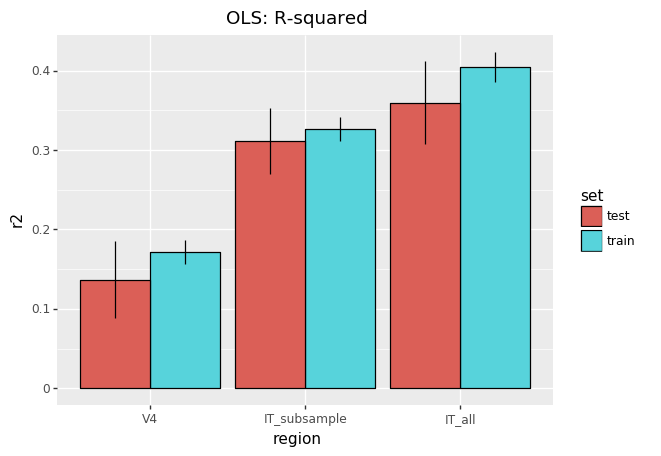

<ggplot: (161284308733)>

In [10]:
# plot performance
df_V4 = pd.DataFrame(results_V4)
df_V4['region'] = 'V4'
df_IT_subsample = pd.DataFrame(results_IT_subsample)
df_IT_subsample['region'] = 'IT_subsample'
df_IT = pd.DataFrame(results_IT)
df_IT['region'] = 'IT_all'

df_performance = pd.concat([df_V4,df_IT_subsample, df_IT])
df_performance = df_performance.melt(id_vars=['region'], value_vars=['train', 'test'], 
                                     value_name='r2', var_name = 'set')
df_performance['region'] = pd.Categorical(df_performance['region'], ordered=True, categories=['V4', 'IT_subsample', 'IT_all'])
# df_performance['set'] = pd.Categorical(df_performance['set'], ordered=True, categories=['train', 'test'])
# print(df_performance)

# ggplot
ggplot(df_performance, aes('region', 'r2', fill = 'set')) +\
stat_summary(fun_y = np.mean,
                geom = 'bar',
                color = 'black',
                position = position_dodge(width = .9)) +\
stat_summary(fun_data = 'mean_sdl', # error_bar: standard deviation
                geom = 'linerange',
                position = position_dodge(width = .9)) +\
labs(title = 'OLS: R-squared')


#### Ridge regression 

In [11]:
def train_and_test_Ridge(X, y, splits, alpha_options):
    """Routine for contructing, training and testing Ridge regression
       
       Arguments: 
           X: (K, M) feature array where K = number of stimuli and M = number of features
           y: length-K vector of values to be predicted
           splits: splits of data (constructed by calling the get_splits function)
           
       Returns:
           dictionary summary of training and testing results
    
    """
    results = []
    for alpha in alpha_options:    
        train_r2 = []
        test_r2 = []
        for split in splits:
            lr = Ridge(alpha=alpha)

            train_inds = split['train']
            test_inds = split['test']

            lr = lr.fit(X[train_inds, :], y[train_inds])
            r2_lr_test = lr.score(X[test_inds, :], y[test_inds])

            test_r2.append(r2_lr_test)

        # get mean performance in test-set
        test_r2 = np.array(test_r2).mean()
        results.append(test_r2)
    
    # find the best alpha
    best_alpha_idx = np.argmax(results)
    best_alpha = alpha_options[best_alpha_idx]
#     print("results: ", results)
#     print(best_alpha_idx)
#     print(alpha_options[best_alpha_idx])
        
    
    # apply the best alpha
    train_r2 = []
    test_r2 = []
    for split in splits:
        lr = Ridge(alpha=best_alpha)
        
        train_inds = split['train']
        test_inds = split['test']
        
        lr = lr.fit(X[train_inds, :], y[train_inds])
        r2_lr_train = lr.score(X[train_inds, :], y[train_inds])
        r2_lr_test = lr.score(X[test_inds, :], y[test_inds])
        
        train_r2.append(r2_lr_train)
        test_r2.append(r2_lr_test)
        
    train_r2 = np.array(train_r2)
    test_r2 = np.array(test_r2)
    results = {'train': train_r2, 'test': test_r2}
    
    return results, best_alpha

In [12]:
# get Ridge performance
alphas = [1e-7, 1e-5, 1e-3, 1e-2, 1e-1, 1, 10, 100]

results_V4_ridge, best_alpha_V4 = train_and_test_Ridge(X = V4_Neural_Data, y = image_size, splits = splits, alpha_options = alphas)
results_IT_subsample_ridge, best_alpha_IT_subsample = train_and_test_Ridge(X = IT_Neural_Data_subsample, 
                                                                           y = image_size, splits = splits, alpha_options = alphas)
results_IT_ridge, best_alpha_IT = train_and_test_Ridge(X = IT_Neural_Data, y = image_size, splits = splits, alpha_options = alphas)

# print(best_alpha_V4)
# print(best_alpha_IT_subsample)
# print(best_alpha_IT)

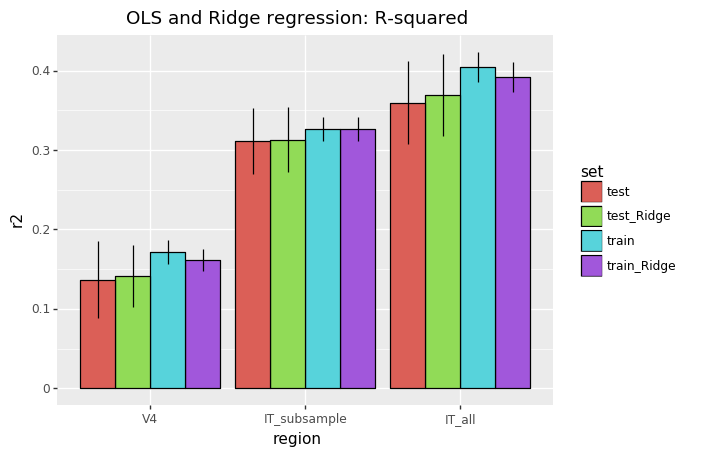

<ggplot: (-9223371875570468380)>

In [13]:
# plot Ridge performance
df_V4_ridge = pd.DataFrame(results_V4_ridge)
df_V4_ridge['region'] = 'V4'
df_IT_subsample_ridge = pd.DataFrame(results_IT_subsample_ridge)
df_IT_subsample_ridge['region'] = 'IT_subsample'
df_IT_ridge = pd.DataFrame(results_IT_ridge)
df_IT_ridge['region'] = 'IT_all'

df_performance_ridge = pd.concat([df_V4_ridge, df_IT_subsample_ridge, df_IT_ridge])
df_performance_ridge = df_performance_ridge.melt(id_vars=['region'], value_vars=['train', 'test'], 
                                     value_name='r2', var_name = 'set')
df_performance_ridge['set'] = df_performance_ridge['set'].replace({'train': 'train_Ridge', 'test':'test_Ridge'})
# print(df_performance_ridge)

# combined OLS and Ridge results
df_performance_combined = df_performance.append(df_performance_ridge)
df_performance_combined['region'] = pd.Categorical(df_performance_combined['region'], ordered=True, 
                                                   categories=['V4', 'IT_subsample', 'IT_all'])
# print(df_performance_combined)


# ggplot
ggplot(df_performance_combined, aes('region', 'r2', fill = 'set')) +\
stat_summary(fun_y = np.mean,
                geom = 'bar',
                color = 'black',
                position = position_dodge(width = .9)) +\
stat_summary(fun_data = 'mean_sdl', # error_bar: standard deviation
                geom = 'linerange',
                position = position_dodge(width = .9)) +\
labs(title = 'OLS and Ridge regression: R-squared')

__Conclusion:__ According to the performance in the test set, IT neurons predicts bettern than V4 neurons,and Ridge regression, with L2 regularization, generally performs slightly better than OLS.

In [14]:
# RidgeCV

# V4
print('\nBest alpha for V4 (in house):', best_alpha_V4)
best_alpha_V4_RidgeCV = []
for split in splits:
    lr = RidgeCV(alphas=alphas)
    train_inds = split['train']
    test_inds = split['test']
    lr = lr.fit(V4_Neural_Data[train_inds, :], image_size[train_inds])
    best_alpha_V4_RidgeCV.append(lr.alpha_)
# get the most common alpha from the results of different splits
print('Best alpha for V4 (from RidgeCV): ', stats.mode(best_alpha_V4_RidgeCV, axis=None)[0])


# IT
print('\nBest alpha for IT (in house):', best_alpha_IT)
best_alpha_IT_RidgeCV = []
for split in splits:
    lr = RidgeCV(alphas=alphas)
    train_inds = split['train']
    test_inds = split['test']
    lr = lr.fit(IT_Neural_Data[train_inds, :], image_size[train_inds])
    best_alpha_IT_RidgeCV.append(lr.alpha_)
# get the most common alpha from the results of different splits
print('Best alpha for IT (from RidgeCV): ', stats.mode(best_alpha_IT_RidgeCV, axis=None)[0])


Best alpha for V4 (in house): 100
Best alpha for V4 (from RidgeCV):  [100.]

Best alpha for IT (in house): 100
Best alpha for IT (from RidgeCV):  [100.]


__Conclusion:__ The best alpha for Ridge regression is 100.

### 1.1.2 Problem 2: Predicting neural responses from neural responses

In [15]:
# prepare Chabo and Tito data
animal_info = np.array(Ventral_Dataset['neural_meta']['ANIMAL_INFO'])
Chabo_neurons = np.where(animal_info == b'Chabo')[0]
Tito_neurons = np.where(animal_info == b'Tito')[0]
# print(Chabo_neurons)
# print(Tito_neurons)

# get valid neurons
valid_neurons = np.sort(np.append(IT_NEURONS[:], V4_NEURONS))
# print(valid_neurons.shape)

# retain only valid neurons
mask_Chabo = np.isin(Chabo_neurons, valid_neurons)
Chabo_neurons_valid = Chabo_neurons[mask_Chabo]
mask_Tito = np.isin(Tito_neurons, valid_neurons)
Tito_neurons_valid = Tito_neurons[mask_Tito]
# print(Chabo_neurons_valid)
# print(Tito_neurons_valid)

# neural data
Chabo_Neural_Data = Neural_Data[:, Chabo_neurons_valid]
Tito_Neural_Data = Neural_Data[:, Tito_neurons_valid]
Tito_Neural_Data_average = Tito_Neural_Data.mean(axis = 1)
print(Chabo_Neural_Data.shape)
print(Tito_Neural_Data_average.shape)


(5760, 128)
(5760,)


In [16]:
def train_and_test_regularized_regressionCV(X, y, splits, alpha_options, regularization_type = 'Ridge'):
    """Routine for contructing, training and testing Ridge regression
       
       Arguments: 
           X: (K, M) feature array where K = number of stimuli and M = number of features
           y: length-K vector of values to be predicted
           splits: splits of data (constructed by calling the get_splits function)
           
       Returns:
           dictionary summary of testing results and best alpha
    
    """
    train_r2 = []
    test_r2 = []
    best_alpha = []
    for split in splits:
        if regularization_type == 'Ridge':
            lr = RidgeCV(alphas=alpha_options)
        if regularization_type == 'Lasso':
            lr = LassoCV(alphas=alpha_options, max_iter=1000)
        
        train_inds = split['train']
        test_inds = split['test']
        
        lr = lr.fit(X[train_inds, :], y[train_inds])
        r2_lr_train = lr.score(X[train_inds, :], y[train_inds])
        r2_lr_test = lr.score(X[test_inds, :], y[test_inds])
        
        train_r2.append(r2_lr_train)
        test_r2.append(r2_lr_test)
        best_alpha.append(lr.alpha_)
#         print('best alpha:', lr.alpha_)

    train_r2 = np.array(train_r2)    
    test_r2 = np.array(test_r2)
    results = {'train':train_r2, 'test': test_r2, 'best alpha': best_alpha}
    
    return results

    

In [17]:
alphas = [1e-6, 1e-5, 1e-3, 1e-2, 1e-1, 1, 10, 100, 1e3, 1e5]

results_RidgeCV = train_and_test_regularized_regressionCV(X = Chabo_Neural_Data, y = Tito_Neural_Data_average, splits = splits, 
                                                          alpha_options = alphas, regularization_type = 'Ridge')
results_LassoCV = train_and_test_regularized_regressionCV(X = Chabo_Neural_Data, y = Tito_Neural_Data_average, splits = splits, 
                                                          alpha_options = alphas, regularization_type = 'Lasso')

print('Ridge best alpha: ', results_RidgeCV['best alpha'])
print('Lasso best alpha: ', results_LassoCV['best alpha'])

Ridge best alpha:  [100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0]
Lasso best alpha:  [1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05]


In [18]:
def train_and_test_PLSRegression(X, y, splits, n_comp_options, average_splits = True):
    """Routine for contructing, training and testing PLS regression
       
       Arguments: 
           X: (K, M) feature array where K = number of stimuli and M = number of features
           y: length-K vector of values to be predicted
           splits: splits of data (constructed by calling the get_splits function)
           
       Returns:
           dictionary summary of testing results and best n_components
    
    """
    results = {'test':[], 'train':[]}
    for n_comp in n_comp_options:
        print('n_comp = ', n_comp)
        train_r2 = []
        test_r2 = []
        for split in splits:
            lr = PLSRegression(n_components=n_comp)

            train_inds = split['train']
            test_inds = split['test']

            lr = lr.fit(X[train_inds, :], y[train_inds])
            r2_lr_train = lr.score(X[train_inds, :], y[train_inds])
            r2_lr_test = lr.score(X[test_inds, :], y[test_inds])
            
            train_r2.append(r2_lr_train)
            test_r2.append(r2_lr_test)

        # get mean performance in test-set
        if average_splits:
            test_r2 = np.array(test_r2).mean() 
            train_r2 = np.array(train_r2).mean()
            
        test_r2 = np.array(test_r2)
        train_r2 = np.array(train_r2)
        results['test'].append(test_r2)
        results['train'].append(train_r2)
    
    return results
    
    

n_comp =  1
n_comp =  2
n_comp =  3
n_comp =  4
n_comp =  5
n_comp =  6
n_comp =  7
n_comp =  8
n_comp =  9
n_comp =  10
n_comp =  12
n_comp =  14
n_comp =  16
n_comp =  18
n_comp =  20
n_comp =  22
n_comp =  24


Text(0, 0.5, 'r-squared')

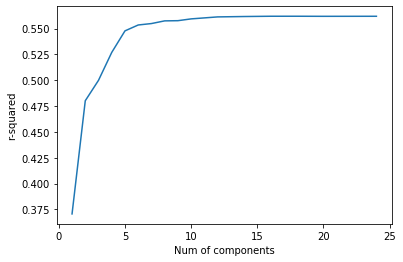

In [19]:
n_components = np.append(np.arange(start = 1, stop = 10, step = 1), np.arange(start = 10, stop = 25, step = 2))

results_PLS_for_comparison = train_and_test_PLSRegression(X = Chabo_Neural_Data, y = Tito_Neural_Data_average, splits = splits, 
                             n_comp_options = n_components)

# plot performance agains n_components
plt.plot(n_components, results_PLS_for_comparison['test'])
plt.xlabel('Num of components')
plt.ylabel('r-squared')

In [20]:
# the performance stablizes n_components >= 15 approximates 
# choose n_components = 15

best_n_components = [15]
results_PLS = train_and_test_PLSRegression(X = Chabo_Neural_Data, y = Tito_Neural_Data_average, splits = splits, 
                             n_comp_options = best_n_components, average_splits = False)
# print(results_PLS)

n_comp =  15


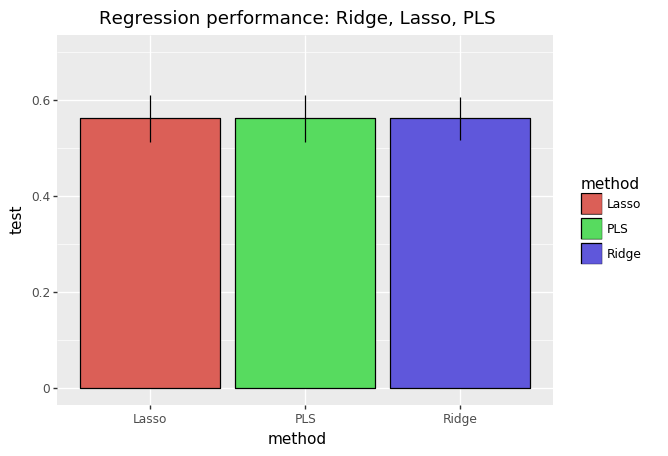

<ggplot: (-9223371875567955915)>

In [22]:
# plot
df_RidgeCV = pd.DataFrame(results_RidgeCV)
df_RidgeCV['method'] = 'Ridge'
df_LassoCV = pd.DataFrame(results_LassoCV)
df_LassoCV['method'] = 'Lasso'
df_PLS = pd.DataFrame(results_LassoCV)
df_PLS['method'] = 'PLS'

df_combined = pd.concat([df_RidgeCV, df_LassoCV, df_PLS], sort=False)
# df_combined['method'] = pd.Categorical(df_combined['method'], ordered=True, categories=['Ridge', 'Lasso', 'PLS'])
# print(df_combined)

# ggplot
ggplot(df_combined, aes('method', 'test', fill = 'method')) +\
stat_summary(fun_y = np.mean,
                geom = 'bar',
                color = 'black') +\
stat_summary(fun_data = 'mean_sdl',# error_bar: standard deviation
                geom = 'linerange') +\
ylim(0, 0.7) +\
labs(title = 'Regression performance: Ridge, Lasso, PLS')


In [25]:
# mean performance
df_combined[['method', 'test', 'train']].groupby('method').mean()

,test,train
method,,
Lasso,0.562315,0.587158
PLS,0.562315,0.587158
Ridge,0.562455,0.580111


__Conclusion:__ The 3 regressions (Ridge, Lasso, PLS) have almost same performance.

## 1.2 Regression in self-regulation ontology data
### 1.1.2 Problem 3: Regression to self regulation measures

In [26]:
df_task_survey = pd.read_csv('data/task_survey_measures.csv')
df_task_survey_retest = pd.read_csv('data/retest_task_survey_measures.csv')
df_self_regulation = pd.read_csv('data/self_regulation_measures.csv')

print(df_task_survey.shape)
print(df_task_survey_retest.shape)
print(df_self_regulation.shape)

(522, 194)
(151, 194)
(522, 9)


In [27]:
# prepare X
print(type(df_task_survey))
# df_task_survey

survey_cols = []
task_cols = []
for col in df_task_survey.columns[1:]:
    if 'survey' in col:
        survey_cols.append(col)
    else:
        task_cols.append(col)

print('number of surveys:', len(survey_cols))
print('number of tasks:', len(task_cols))

survey_arr = np.asarray(df_task_survey[survey_cols])
task_arr = np.asarray(df_task_survey[task_cols])

# make sure task and survey have the same number of featuress
task_subsample = np.random.choice(len(task_cols), len(survey_cols), replace=False)
task_arr = task_arr[:, task_subsample]

print("surver_arr shape:", survey_arr.shape)
print("task_arr shape:", task_arr.shape)

<class 'pandas.core.frame.DataFrame'>
number of surveys: 69
number of tasks: 124
surver_arr shape: (522, 69)
task_arr shape: (522, 69)


In [28]:
# prepare y
regulation_arr = np.asarray(df_self_regulation)
regulation_arr.shape

(522, 9)

In [30]:
# get splits of the data
splits = get_splits(observation_inds=np.arange(regulation_arr.shape[0]),
               num_splits=20,
               num_test=100,
               num_train=400,
               seed=0)

# print(splits[0])
len(splits)

20

In [31]:
alphas = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100, 1e3, 1e4, 1e5, 
          1e6, 1e7, 1e8, 1e9, 1e10, 1e11, 1e12, 1e13, 1e14, 1e15, 
          1e20, 1e25, 1e30, 1e40, 1e50, 1e60, 1e70, 1e80, 1e90, 1e100]

df_results_all = pd.DataFrame()
for i in range(1, len(df_self_regulation.columns)):
    results_survey = train_and_test_regularized_regressionCV(X = survey_arr, y = regulation_arr[:, i], splits = splits, 
                                                              alpha_options = alphas, regularization_type = 'Ridge')
    results_task = train_and_test_regularized_regressionCV(X = task_arr, y = regulation_arr[:, i], splits = splits, 
                                                              alpha_options = alphas, regularization_type = 'Ridge')

#     print('Survey results:',results_survey)
#     print('Task results:',results_task)
    print('\n Self-regulation measure:', df_self_regulation.columns[i])
    print('Survey log10(best alpha):', np.log10(results_survey['best alpha']))
    print('Task log10(best alpha):', np.log10(results_task['best alpha']))
       
    df_results_survey = pd.DataFrame(results_survey)
    df_results_survey['predictor'] = 'survey'
    df_results_task = pd.DataFrame(results_task)
    df_results_task['predictor'] = 'task'
    df_resutls_combined = df_results_survey.append(df_results_task)
    df_resutls_combined['regulation_measure'] = df_self_regulation.columns[i]
    
    df_results_all = df_results_all.append(df_resutls_combined)


 Self-regulation measure: Drug Use
Survey log10(best alpha): [4. 3. 3. 3. 4. 3. 3. 3. 3. 4. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.]
Task log10(best alpha): [ 9.  8.  8.  7.  8.  6.  6.  9. 10.  8.  8.  8.  9.  6.  6.  6.  8.  6.
  8.  8.]

 Self-regulation measure: Mental Health
Survey log10(best alpha): [2. 3. 2. 2. 2. 2. 2. 3. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
Task log10(best alpha): [100.  70.  50.  50.  25.  80.  40.  25.  25.  25.  30.  90.  25.  25.
  80.  25.  30.  25.  25.  30.]

 Self-regulation measure: Problem Drinking
Survey log10(best alpha): [4. 4. 3. 3. 3. 3. 3. 3. 4. 3. 3. 3. 3. 3. 3. 4. 3. 3. 3. 3.]
Task log10(best alpha): [40.  6. 25. 40. 30. 25. 30. 30. 25. 25. 25. 25. 25.  5. 30. 25. 50. 30.
 25. 25.]

 Self-regulation measure: Daily Smoking
Survey log10(best alpha): [3. 3. 2. 2. 2. 3. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
Task log10(best alpha): [2. 2. 2. 2. 2. 2. 3. 2. 2. 2. 2. 3. 2. 2. 3. 2. 2. 3. 3. 2.]

 Self-regulation measure: Binge Drinking
Survey log10(best

In [32]:
df_performance = df_performance.melt(id_vars=['region'], value_vars=['train', 'test'], 
                                     value_name='r2', var_name = 'set')
df_results_all

,train,test,best alpha,predictor,regulation_measure
0,0.059939,0.108342,10000.0,survey,Drug Use
1,0.113330,0.079082,1000.0,survey,Drug Use
2,0.125558,0.015607,1000.0,survey,Drug Use
3,0.151777,-0.136644,1000.0,survey,Drug Use
4,0.049905,0.060993,10000.0,survey,Drug Use
...,...,...,...,...,...
15,0.163231,0.028364,100.0,task,Income / Life Milestones
16,0.100426,-0.076632,1000.0,task,Income / Life Milestones
17,0.170742,-0.007332,100.0,task,Income / Life Milestones
18,0.091789,0.022913,1000.0,task,Income / Life Milestones


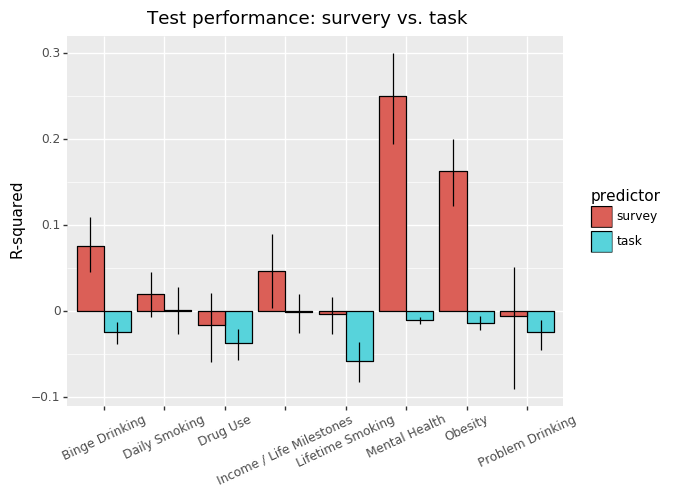

<ggplot: (-9223371875567601590)>


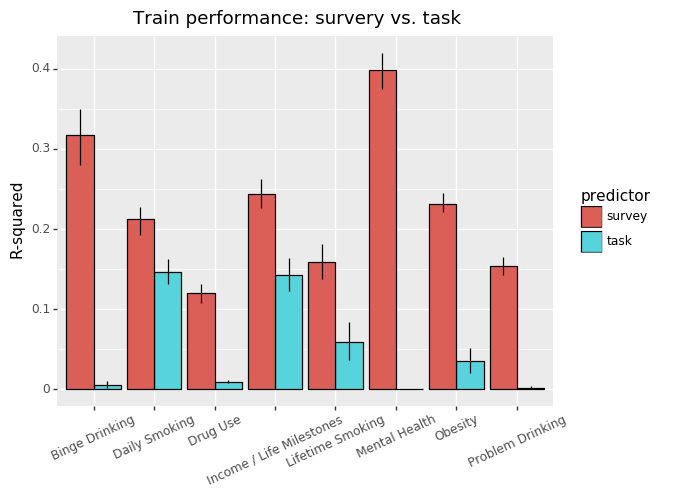

<ggplot: (-9223371875569391465)>


In [37]:
# plot results
p_test = (ggplot(df_results_all, aes('regulation_measure', 'test', fill = 'predictor')) +\
stat_summary(fun_y = np.mean,
                geom = 'bar',
                color = 'black',
                position = position_dodge(width = .9)) +\
stat_summary(fun_data = 'mean_cl_boot', # error_bar: confidence interval
                geom = 'linerange',
                position = position_dodge(width = .9)) +\
labs(title = 'Test performance: survery vs. task', y = 'R-squared', x = "") +\
theme(axis_text_x=element_text(rotation=25)))
print(p_test)

p_train = (ggplot(df_results_all, aes('regulation_measure', 'train', fill = 'predictor')) +\
stat_summary(fun_y = np.mean,
                geom = 'bar',
                color = 'black',
                position = position_dodge(width = .9)) +\
stat_summary(fun_data = 'mean_cl_boot', # error_bar: confidence interval
                geom = 'linerange',
                position = position_dodge(width = .9)) +\
labs(title = 'Train performance: survery vs. task', y = 'R-squared', x = "") +\
theme(axis_text_x=element_text(rotation=25)))
print(p_train)

__Conclusion:__ Generall, survey and task data are not very predictive of self-regulation measures (low test R-squared). Relatively, survey data predicts better than task data.